# Gaussian CS for Simple Convolutional Priors

**Setup**:

- Gaussian compressive sensing: 
$$
\begin{align*}
    y = Ax_0 + \eta \qquad A \in \mathbb{R}^{m \times n},\ A_{ij} \sim \mathcal{N}(0, 1/\sqrt{m}) \qquad \eta \sim \mathcal{N}(0, \sigma^2 I_m)
\end{align*}
$$
- We investigate two priors for $x_0$:
    1. **Sparse-Conv**: $x_0 \sim C z$ where $C$ is a random convolutional matrix and $z$ is Gaussian-Bernouilli. 
    2. **Sparse-DCT-Conv**: $x_0 \sim C D^T z$ where $C$ is a random convolutional matrix, $D$ is a discrete cosine transform, and $z$ is Gaussian-Bernouilli. 
- The goal is to test whether random convolutional matrices are pathological for AMP. 

**Details of Sparse-Conv and Sparse-DCT-Conv priors**: 

- Convolutional Gaussian ensemble (CG), $\mathcal{C}(N, k, \sigma)$. 

    1. We define the CG ensemble as matrices of the form $W = \texttt{Circ}[\texttt{Zero-Pad}_{N, k}[w]]$ where $w \sim \mathcal{N}(0, (1\sqrt{k}) I_k)$.
    
    2. $\texttt{Zero-Pad}_{N, k}[w]$ maps $w \in \mathbb{R}^k$ to $w' \in \mathbb{R}^N$ by adding zero components to $w$. For convention we use a circular indexing and assume $k$ is odd, $k = 2k' + 1$. So $w$ has indices $-k', -k'+1, \ldots, -1, 0, 1, \ldots, k'$. Graphically,
    $$
    \begin{align*}
    \texttt{Zero-Pad}_{N, k}[w] = 
    \begin{bmatrix} w_0& w_1& \ldots& w_{k'}& 0& 0&  \ldots& 0& 0& w_{-k'}& w_{-k'+1}& \ldots& w_{-1} \end{bmatrix}
    \in \mathbb{R}^N
    \end{align*}
    $$ 
    
    3. $\texttt{Circ}[v]$ maps a vector $v \in \mathbb{R}^{N}$ to the circulant matrix $W \in \mathbb{R}^{N \times N}$ whose first row is $v$. Grahpically,
    $$
    \begin{align*}
    \texttt{Circ}[v] & = 
    \begin{bmatrix}
    v_1 & v_2 & v_3 & \ldots & v_{N-1} & v_{N} \\
    v_2 & v_3 & v_4 & \ldots & v_1 & v_{N} \\
    & & & & & \ddots 
    \end{bmatrix}
    \end{align*}
    $$

- Note that $\mathcal{C}(N, k, \sigma)$ is a distribution over $N \times N$ matrices and there is no natural way to incorporate subsampling. This is why $C$ a part of the prior instead of the sensing matrix.
- **Sparse-Conv**: the prior is defined by parameters $(\rho, \sigma_z, \sigma_w, k)$. Signals $x_0 = Cz$ are generated by randomly sampling $C \sim \mathcal{C}(N, k, \sigma_w)$ and $z \sim \text{Gauss-Bernouilli}(\rho, \sigma_z)$ 
- **Sparse-DCT-Conv**: same as Sparse-Conv but $x_0 = CD^T z$ where $D$ is a discrete cosine transform. 

In [ ]:
from invert_conv_matrix import plot_recovery
import numpy as np 
import matplotlib.pyplot as plt

rhos = [0.25, 0.5, 0.75]
alphas = 1 - np.arange(0, 1, 0.05)

plt.subplot(1, 2, 1)
plot_recovery(rhos, alphas, N=1000, k=5, sparse_in_dct=False, delta=1e-4, n_rep=10)
plt.subplot(1, 2, 2)
plot_recovery(rhos, alphas, N=1000, k=5, sparse_in_dct=True, delta=1e-4, n_rep=10)
plt.gcf().set_size_inches(20, 10)

plt.show()

![](Gaussian_CS_Conv.png)
**Result**: MSE of an estimate $\hat{x} \approx x$ found using either AMP (solid lines) or convex optimization routines (dotted lines). The left plot corresponds to the Sparse-Conv prior on $x_0$ while the right corresponds to Sparse-DCT-Conv. Each MSE estimate is averaged over 10 runs.

# CS with Spatially Coupled / Multi Channel Convolutions

**Setup**:
- Compressive sensing with random multi-channel convolutional measurements, $A \sim \text{MC}(n, c_{\text{in}}, c_{\text{out}}, k, \sigma)$. The $\text{MC}$ ensemble is defined below.
$$
\begin{align*}
    y = Ax_0 + \eta \qquad \eta \sim \mathcal{N}(0, \sigma^2 I_m)
\end{align*}
$$
- In this case the priors are: 
    1. **Sparsity**: $x_0$ is Gaussian-Bernouilli. 
    2. **DCT-Sparsity**: $x_0 \sim D^T z$ where $D$ is a discrete cosine transform and $z$ is Gaussian-Bernouilli. 
- The goal is to study a convolutional matrix ensemble *with subsampling*. 
- A second goal is to connect multi-channel convolutional layers to spatially coupled sampling operators. This relationship is described below

**Details of Multi-Channel Convolutional Measurements**
- Multichannel Convolutional Gaussian ensemble (MC), $\text{MC}(n, c_{\text{in}}, c_{\text{out}}, k, \sigma)$. 
    1. This ensemble is a random version of multi-channel convolutional layers used in neural networks. 
    2. Signals are decomposed into channels, like RGB channels of color images. Here signals are $x \in \mathbb{R}^{n \times c}$ consisting of $c$ channels, each an $n$-dimensional vector. Equivalently $x$ can be vectorized by concatenating all channels into a $\mathbb{R}^{n c_{\text{in}}}$ vector.
    3. Here is the actual matrix ensemble: $ M \sim \text{MC}(n, c_{\text{in}}, c_{\text{out}}, k, \sigma)$ has $M \in \mathbb{R}^{n c_{\text{out}} \times n c_{\text{in}} }$ with block matrix structure,
    $$
    \begin{align*}
        M = \begin{bmatrix}
        W_{1,1} & W_{1,2} & \cdots & W_{1,c_\text{in}} \\
        \vdots & & & \vdots \\
        W_{c_{\text{out}}, 1} & W_{c_{\text{out}}, 2} & \cdots & W_{c_{\text{in}}, c_{\text{out}}} 
        \end{bmatrix}
        \qquad W_{ij} \sim \mathcal{C}(n, k, \sigma)
    \end{align*} 
    $$
    4. Intuitively, each output channel is a linear combination of convolved input channels. The $W_{ij}$ matrix convolves input channel $j$ which is a mixture component of output channel $i$. 
    5. When used to generate compressive measurements, the measurement ratio is $\alpha = \frac{c_{out}}{c_{in}}$. 
    
- Relationship of multichannel convolutions to spatially coupled sampling matrices (ex. [Barbier, Shülke, Krzakala 2015](https://arxiv.org/pdf/1312.1740.pdf))
    - For spatial coupling, channels take the form of signal blocks $x_1, x_2, \ldots$. Output channels are averaged over a small number of locally coupled blocks according to $w$. These blocks are Fourier subsampled, which is a specialization of convolution operations. See Figure 1 of [Barbier, Shülke, Krzakala 2015](https://arxiv.org/pdf/1312.1740.pdf), <img src="Spatially_Coupled.png" style="width: 500px" />
    
    - For multi-channel convolutions, an output channel $i$ is an average over convolved input channels, analogous to spatial coupling where all locations $j = 1 ... c_\text{in}$ are densely coupled.
    - The convolution operation represents a 'soft' Fourier subsampling of the signal component at each location. In the Fourier domain convolutions act diagonally, so they rescale frequency components instead of selectively zeroing some of them out. 

In [ ]:
from invert_conv_matrix import plot_recovery, plot_conv_sensing
import numpy as np 
import matplotlib.pyplot as plt

rhos = [0.25, 0.5, 0.75]
alphas = 1 - np.arange(0.05, 1, 0.05)


plt.subplot(1, 2, 1)
plot_conv_sensing(rhos, alphas, in_channels=20, n=50, k=5, sparse_in_dct=False, delta=1e-4, n_rep=10, omit_cvx=True)
plt.subplot(1, 2, 2)
plot_conv_sensing(rhos, alphas, in_channels=20, n=50, k=5, sparse_in_dct=True, delta=1e-4, n_rep=10, omit_cvx=True)
plt.gcf().set_size_inches(20, 10)
plt.show()

![](Gaussian_MCS_Conv.png)
**Result**: MSE of an estimate $\hat{x} \approx x$ found using either AMP (solid lines) or convex optimization routines (dotted lines). The left plot corresponds to the sparsity prior on $x_0$ while the right corresponds to DCT-sparsity. Each MSE estimate is averaged over 10 runs.

# Sanity Check

The following plots test recovery error for AMP on gaussian compressed sensing of sparse signals.

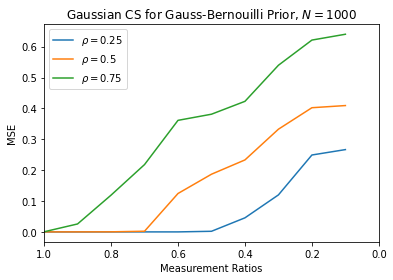

In [1]:
from invert_conv_matrix import plot_recovery
import numpy as np 
import matplotlib.pyplot as plt

rhos = [0.25, 0.5, 0.75]
alphas = 1 - np.arange(0, 1, 0.1)

plot_recovery(rhos, alphas, N=1000, k=5, sparse_in_dct=False, delta=1e-4, n_rep=1, omit_cvx=True, prior="sparse")